In [5]:
import ee
import geemap
import os
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
from functions_floes import *
import earthaccess
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geemap
import xarray as xr
import h5netcdf

In [2]:
#!pip install ffmpeg-python

In [6]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [22]:
region = ee.Geometry.BBox(-51, -78.5, -41, -76.5) # Landfast ice in the Weddell Sea

# Mukund's ROI
bbox = [-10, 72.6, 12, 79.2]
# bbox = [-176.3, -76.3, -153.9, -74.4]
region = ee.Geometry.BBox(bbox[0], bbox[1], bbox[2], bbox[3]) #ee.Geometry.Rectangle(bbox)
point = ee.Geometry.Point([np.mean([bbox[0], bbox[2]]), np.mean([bbox[1], bbox[3]])]).buffer(20000)
# Approximately (72.6 to 79.2 N) and (-10 to 12 E) April to May 2023
# Approximately (-76.3 to -74.4 S) and (-176.3 to -153.9 W) November - December 2023

# Grounded icebergs ROI
sub = "EW" #"EW"

if sub == "EW":
    point = [-45.14, -76.6] # South Weddell
    offset = [3, 0.6]
elif sub == "W":
    point = [-58.4,-71.23] # West Weddell
    offset = [1.75, 0.60]
else:
    print("SET SUBAREA!! (E or EW)")
    
bbox = [point[0]-offset[0], point[1]-offset[1], point[0]+offset[0], point[1]+offset[1]]
region = ee.Geometry.Point(point).buffer(50000)
region = ee.Geometry.BBox(bbox[0], bbox[1], bbox[2], bbox[3])


# # point = ee.Geometry.Point([-46, -77.5])

# collection = ee.ImageCollection("COPERNICUS/S1_GRD")\
# .filter(ee.Filter.eq('transmitterReceiverPolarisation', ["HH"]))\
# .filterBounds(region)
# # .filter(ee.Filter.Or(ee.Filter.eq('relativeOrbitNumber_start', 5), ee.Filter.eq('relativeOrbitNumber_start', 34),
# #         ee.Filter.eq('relativeOrbitNumber_start', 136)))

# # 2016: 165
# # 2017: 5

## Load ICESat-2 (via Earthacess) for the overlapped date

In [8]:
import earthaccess
auth = earthaccess.login(persist=True)

In [24]:
img_files

['D:\\Floes\\S1_ground\\S1A_EW_GRDM_1SSH_20200602T013341.tif']

In [27]:
t1, t2

(datetime.datetime(2020, 6, 1, 12, 33, 41),
 datetime.datetime(2020, 6, 2, 14, 33, 41))

In [62]:
date = "20210725"
img_files = glob.glob(f"D:\\Floes\\S1_ground\\S1*_{sub}_*{date}*.tif")

for k, f in enumerate(img_files[:]): #glob.glob("D:\\Floes\\S1_ground\\*.tif"):
    # os.rename(f, f.replace(" .tif", ".tif"))

    dh = 15 # hour difference between S1 and IS2
    
    basename = os.path.basename(f)
    to = datetime.strptime(basename[-19:-4], "%Y%m%dT%H%M%S")
    t1 = to - timedelta(seconds = 3600*dh)
    t2 = to + timedelta(seconds = 3600*dh)

    t1_str = datetime.strftime(t1, "%Y%m%d T%H%M%S")
    t2_str = datetime.strftime(t2, "%Y%m%d T%H%M%S")

    Query = earthaccess.granule_query().concept_id('C2613553243-NSIDC_CPRD')\
    .temporal(t1_str, t2_str).bounding_box(bbox[0], bbox[1], bbox[2], bbox[3])

    N = Query.hits()
    granules = Query.get(N)
    is2_file = earthaccess.open(granules)[-1] #.url
    
    # if os.path.exists(imgname):
    start_time = datetime.strftime(to, "%Y-%m-%d T%H:%M:%S")
    # end_time = datetime.strftime(t2, "%Y-%m-%d T%H:%M:%S")

    proceed = False

    if N > 0:
    
        if sub == "EW":
            dstCrs = {'init': 'EPSG:32723'}
        elif sub == "W":
            dstCrs = {'init': 'EPSG:32721'}
    
        ## Read Sentinel-1 SAR image using raterio ====================================
        img = rasterio.open(f)
        array = img.read(1)
        
        height = array.shape[0]
        width = array.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    
        transform, width, height = calculate_default_transform(img.crs, dstCrs, img.width, img.height, *img.bounds)
        
        # XY projected coordinate of the image
        xs, ys = rasterio.transform.xy(transform, rows, cols)           
        
        xs = np.array(xs)
        ys = np.array(ys)
        # print(img.crs)
    
        img.close()
        # ===========================================================================

        print(start_time, basename, is2_file.url)

        ## ICESat-2 data using Earthaccess ===========================================
        local_file = "D:\\Floes\\ATL10\\" + os.path.basename(is2_file.url)
        df = read_ATL10(local_file, bbox)

        # Convert pandas dataframe into geopandas geodataframe
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))
        # Assign crs information into geodatafraem
        gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        
        # Convert crs of the geodataframe into the crs of the Sentinel-2 image
        gdf = gdf.to_crs(dstCrs['init'])
        
        gdf['x'] = gdf.geometry.apply(lambda x: x.x)
        gdf['y'] = gdf.geometry.apply(lambda x: x.y)

print("Done!")

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

2021-07-25 T01:50:03 S1A_EW_GRDM_1SSH_20210725T015003.tif https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2021/07/25/ATL10-02_20210725043119_04821201_006_01.h5
Done!


In [65]:
beams = pd.unique(gdf['beam'])
gdf2 = gdf[gdf['beam'] == beams[1]].reset_index(drop = True)
gdf2.head(5)

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,geometry,x,y
0,gt2r,-76.000089,-45.831049,0.000000,46.294437,0.063097,2.166667,0.009268,1,192,1920.0,NaN,0.087014,0.0,POINT (477558.280 1564646.797),477558.279539,1.564647e+06
1,gt2r,-76.000252,-45.831154,18.403717,41.996937,0.063395,2.400000,0.009236,1,192,1920.0,0.018203,0.087014,0.0,POINT (477555.695 1564628.583),477555.695330,1.564629e+06
2,gt2r,-76.000447,-45.831281,40.475234,42.645901,0.031719,2.311476,0.008519,1,192,1920.0,0.019887,0.087014,0.0,POINT (477552.581 1564606.741),477552.581267,1.564607e+06
3,gt2r,-76.000640,-45.831407,62.243268,45.404579,0.026726,2.107692,0.007808,1,192,1920.0,0.008232,0.087014,0.0,POINT (477549.484 1564585.203),477549.484048,1.564585e+06
4,gt2r,-76.000871,-45.831561,88.365941,45.173855,0.042810,2.246154,0.010305,1,192,1920.0,0.011697,0.087014,0.0,POINT (477545.698 1564559.366),477545.698490,1.564559e+06


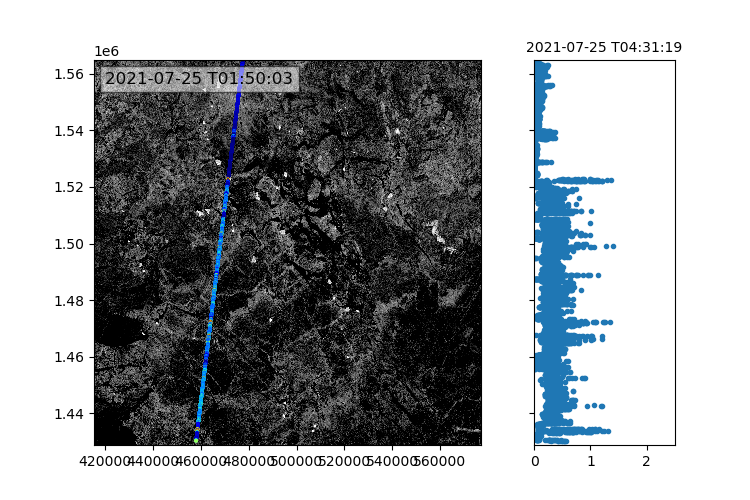

In [66]:
%matplotlib widget

fig, ax = plt.subplots(1,2, figsize = (7.5,5), gridspec_kw={'width_ratios': [5.5,2]},sharey = True)

ax[0].pcolormesh(xs, ys, array, cmap = "Greys_r", vmin = -0.5, vmax = -0.1)
t = ax[0].annotate(f"{start_time}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.5))
# ax[0].set_xlim(420000, 540000)
# ax[0].set_ylim(1440000, 1560000)

ax[0].scatter(gdf2['x'], gdf2['y'], c = gdf2['fb'], s = 2, vmin = 0, vmax = 1, cmap = "jet")

ax[1].plot(gdf2['fb'], gdf2['y'], '.')
ax[1].set_xlim(0, 2.5)
is2_time = datetime.strptime(os.path.basename(is2_file.url)[9:23], "%Y%m%d%H%M%S")
is2_str = is2_time.strftime("%Y-%m-%d T%H:%M:%S")
ax[1].set_title(f"{is2_str}", fontsize=10);

In [33]:
is2_time.strftime("%Y-%m-%d T%H:%M:%S")

'2020-10-13 T17:56:41'

In [16]:
from tkinter import *
from tkinter import ttk

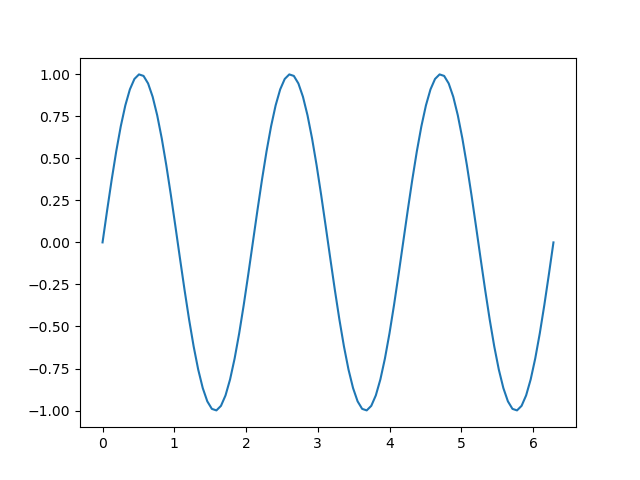

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
plt.plot(x, y)

In [6]:
%matplotlib widget